## F_p>10 and org

F_p>10 - Frequency of heavy precipitaiton, estimated from the frequency of griboxes exceeding 10 mm/day from monhtly average values

<br>
(according Schiro et al, a greater F_p>10 could potentially be associated with increased precipitation efficiency and convective organisation)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
from os.path import expanduser
home = expanduser("~")


import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from plotFuncs_corr import *
import skimage.measure as skm
from scipy import stats

In [2]:
variables_x = [
    'rome',
    'rome_n',
    'o_number'
    ]

variables_y = [
    'Fpr10'
    ]

In [3]:
model = 'GFDL-CM3'
var = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_y[0] +'_historical.nc')
var

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    F_pr10   (time) int64 ...
Attributes:
    description:  Number of gridboxes in daily scene exceeding 10 mm/day

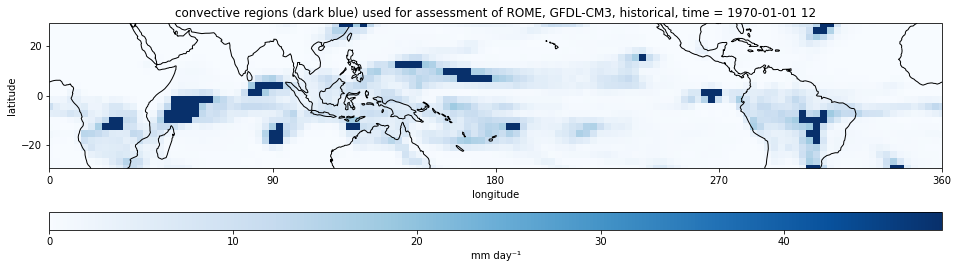

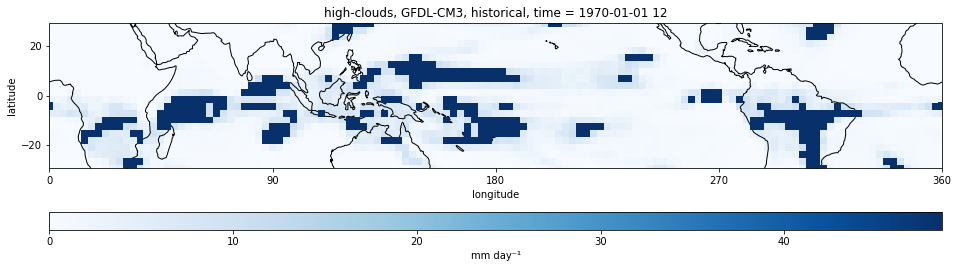

In [4]:
model = 'GFDL-CM3'
experiment = 'historical'

scene_background = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_precip_tMean_historical.nc')['precip_snapshot']
threshold = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_prPercentiles_' + experiment + '.nc').pr97.mean(dim='time').values
L = skm.label(scene_background.where(scene_background>=threshold,0)>0, background=np.nan,connectivity=2)
L = (L>0)*1
labelMatrix = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': scene_background.lat.data, 'lon': scene_background.lon.data}
    )
scene1 = labelMatrix.where(labelMatrix>0)

cmap_background= 'Blues'
cmap = 'Blues_r'
title = 'convective regions (dark blue) used for assessment of ROME, ' + model + ', ' + experiment + ', time = ' + str(scene_background.coords['time'].values)[:13] 
plot_sceneThreshold(scene_background, scene1, cmap_background, cmap, title,fig_width=16 ,fig_height=8)


scene_background = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_precip_tMean_historical.nc')['precip_snapshot']
threshold = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_prPercentiles_' + experiment + '.nc').pr97.mean(dim='time').values
L = skm.label(scene_background.where(scene_background>=10,0)>0, background=np.nan,connectivity=2)
L = (L>0)*1
labelMatrix = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': scene_background.lat.data, 'lon': scene_background.lon.data}
    )
scene2 = labelMatrix.where(labelMatrix>0)

cmap="Blues_r"
title = 'high-clouds, ' + model + ', historical, ' + 'time = ' + str(scene_background.coords['time'].values)[:13] 
plot_sceneThreshold(scene_background, scene2, cmap_background, cmap, title,fig_width=16 ,fig_height=8)


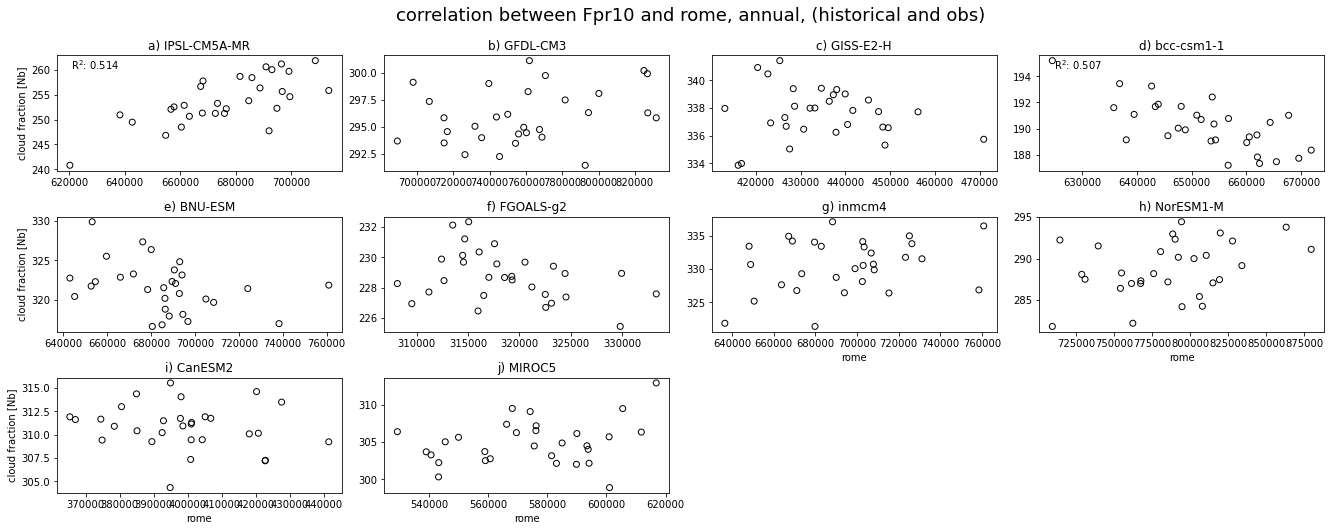

In [8]:
varTypes = [
    # 'wap500'
    # 'area_ascent'
    # 'area_descent'
]

timeMean_options = [
    'annual',
    # 'season',
    # 'season_mean',
    # 'month',
    # 'month_mean',
    # 'day',
    ]
timeMean_option = timeMean_options[0]


models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    'GISS-E2-H',    # 3 # does not have wap
    'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # does not have wap
    # 'HadGEM2-AO',   # 7
    'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    'inmcm4',       # 13 # does not have wap
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]




experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]

observations = [
    # 'GPCP'
]


ds_x = xr.Dataset()
ds_y = xr.Dataset()
for model in models:
    x = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_x[0] +'_' + experiment + '.nc')[variables_x[0]]
    x_resampled = resample(x, timeMean_option)
    x_resampled.attrs['units']= x.units
    ds_x[model] = x_resampled

    y = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_'+ variables_y[0] +'_' + experiment + '.nc')['F_pr10']
    y_resampled = resample(y, timeMean_option)

    if varTypes == 'area_ascent':
        y_resampled = ((y_resampled<0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    if varTypes == 'area_descent':
        y_resampled = ((y_resampled>0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    
    y_resampled.attrs['units']= y.units
    ds_y[model] = y_resampled


for obs in observations:
    x = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_'+ variables1[0] +'.nc')[variables1[0]]
    x_resampled = resample(x, timeMean_option)
    x_resampled.attrs['units']= x.units
    ds_x[model] = x_resampled

    y = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_'+ variables2[0] +'.nc')['wap500_sMean']
    y_resampled = resample(y, timeMean_option)
    if varTypes == 'area_ascent':
        y_resampled = ((y_resampled<0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    if varTypes == 'area_descent':
        y_resampled = ((y_resampled>0)*1).sum(dim=('lat','lon'))/(y_resampled.shape[1]*y_resampled.shape[2])*100
    y_resampled.attrs['units']= y.units
    ds_y[obs] = y_resampled


ymin, ymax = [], []
for dataset in list(ds_y.data_vars.keys()):
    ymin = np.append(ymin, ds_y[dataset].min())
    ymax = np.append(ymax, ds_y[dataset].max())

ymin = np.min(ymin)
ymax = np.max(ymax)

xmin, xmax = [], []
for dataset in list(ds_x.data_vars.keys()):
    xmin = np.append(xmin, ds_x[dataset].min())
    xmax = np.append(xmax, ds_x[dataset].max())
xmin = np.min(xmin)
xmax = np.max(xmax)



title = 'correlation between ' + variables_y[0] + ' and ' + variables_x[0] + ', ' + timeMean_option + ', (' + experiment + ' and obs)'
ylabel= 'cloud fraction'
xlabel = 'rome'
plot_scatter_multiple(ds_x, ds_y, timeMean_option, title, ylabel, xlabel)

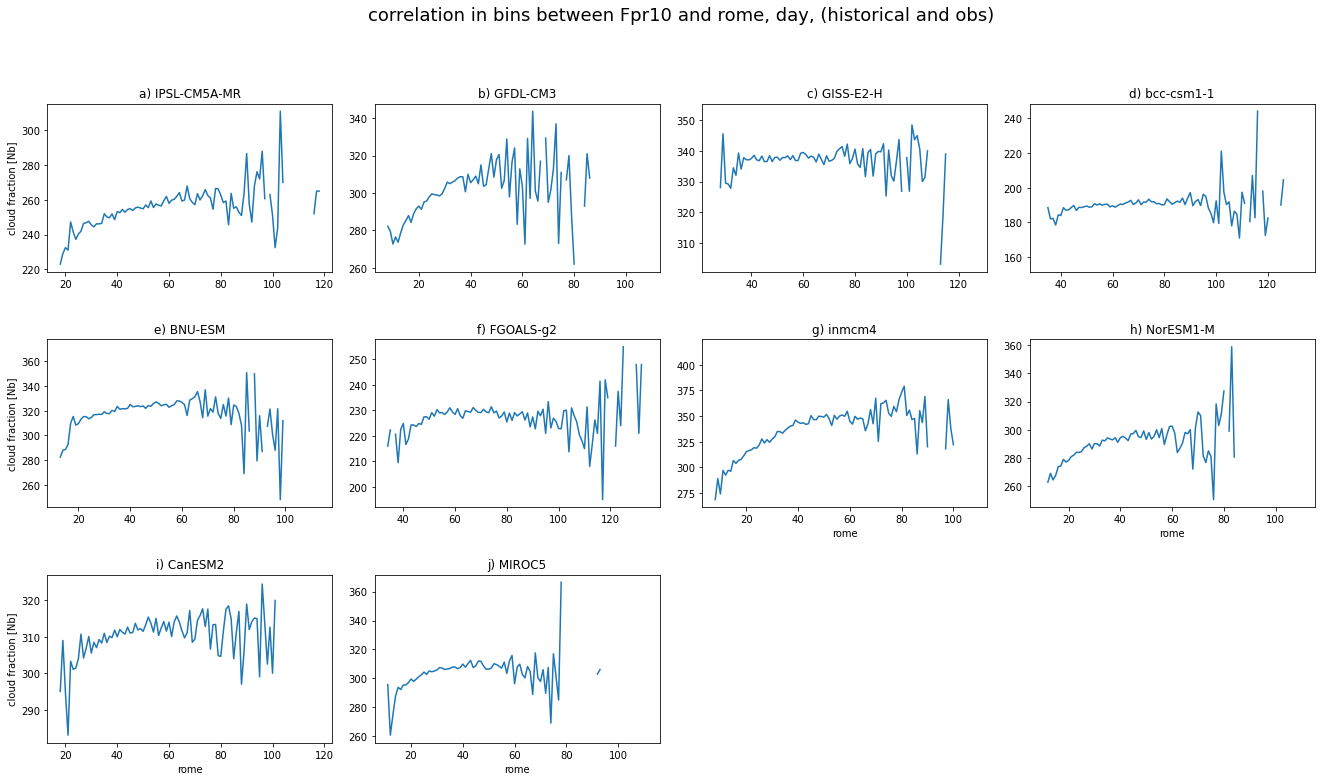

In [7]:
title = 'correlation in bins between ' + variables_y[0] + ' and ' + variables_x[0] + ', ' + timeMean_option + ', (' + experiment + ' and obs)'
ylabel= 'Fpr10'
xlabel = 'rome'
plot_bins_multiple(ds_x, ds_y, timeMean_option, title, ylabel, xlabel)

In [12]:
def plot_snapshot(scene, cmap, title, vmin=None, vmax=None):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = scene.lat
    lon = scene.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(20, 10))
    scene.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(title)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

In [22]:
def plot_timeseries(y, variable_name, series_type):
    plt.figure(figsize=(25,5))
    plt.plot(y)
    plt.axhline(y=y.mean(dim='time'), color='k')
    plt.title(variable_name + ', '+ series_type + ', ' + model + ', ' + experiment)
    plt.ylabel(variable_name + ' ['+y.units+']')
    plt.xlabel(series_type)

In [35]:
def plot_scatter(x,y,scatter_type):
    f, ax = plt.subplots(figsize = (12.5,8))
    res= stats.pearsonr(x,y)

    plt.scatter(x,y,facecolors='none', edgecolor='k')
    plt.ylabel('F_pr10 [Nb]')
    plt.xlabel(org_option + ' ['+ x.units +']')
    title = 'F_pr10 and ' + org_option + ', ' + scatter_type + ', ' + model + ', ' + experiment

    if res[1]<=0.05:
        plt.title(title + ', R$^2$ = '+ str(round(res[0]**2,3)) + ', r=' + str(round(res[0],3)))
    else:
        plt.title(title + ', not statistically significant')

In [38]:
def plot_bins(x,y, bin_type):
    plt.figure(figsize=(15,5))

    bin_width = (org.max() - org.min())/100
    bin_end = org.max()
    bins = np.arange(0, bin_end+bin_width, bin_width)

    areaFrac_bins = []
    for i in np.arange(0,len(bins)-1):
        areaFrac_bins = np.append(areaFrac_bins, F_pr10.where((org>=bins[i]) & (org<=bins[i+1])).mean())
    plt.plot(areaFrac_bins)

    plt.title('F_pr10 and ' + org_option + ', ' + bin_type + ', ' + model + ', ' + experiment)
    plt.ylabel('F_pr10 [Nb]')
    plt.xlabel(org_option + ' ['+ x.units +']')

In [27]:
model='GFDL-CM3'
experiment='historical'
precip = xr.open_dataset(home + '/Documents/data/cmip5/ds' + '/' + model + '_precip_' + experiment + '.nc').precip*24*60*60
precip.attrs['units']='mm/day'


org_options = [
    'rome',
    # 'rome_n',
    # 'o_number'
    ]
org_option = org_options[0]


if org_option == 'rome' or org_option == 'rome_n':
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_rome_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    org = ds[org_option]


In [25]:
F_pr10 = ((precip>10)*1).sum(dim=('lat','lon')) #/(precip.shape[1]*precip.shape[2])*100
F_pr10.attrs['units'] = 'Nb'

### example of F_pr10, daily scene

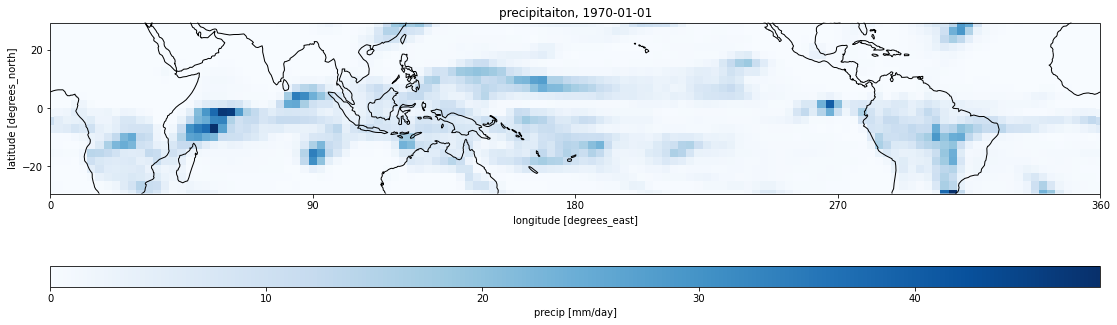

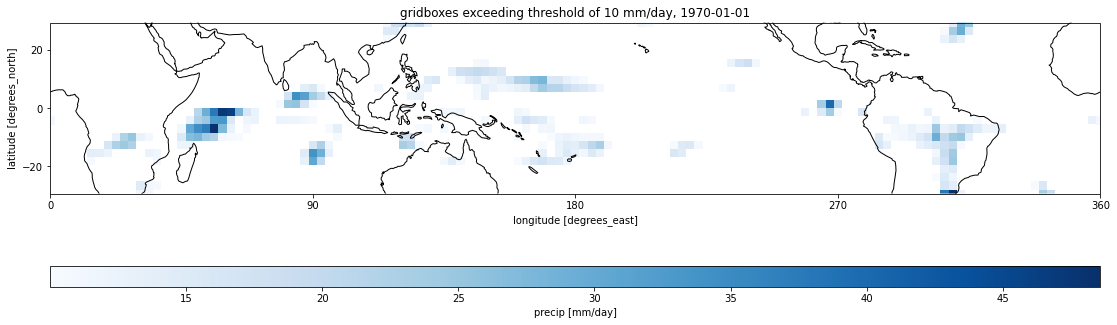

In [20]:
scene = precip.isel(time=0)
cmap = 'Blues'
title = 'precipitaiton, ' + str(precip.isel(time=0).coords['time'].values)[:10]

plot_snapshot(scene, cmap, title)


scene = precip.isel(time=0).where(precip.isel(time=0)>10)
cmap = 'Blues'
title = 'gridboxes exceeding threshold of 10 mm/day, ' + str(precip.isel(time=0).coords['time'].values)[:10]

plot_snapshot(scene, cmap, title)

### individual time series

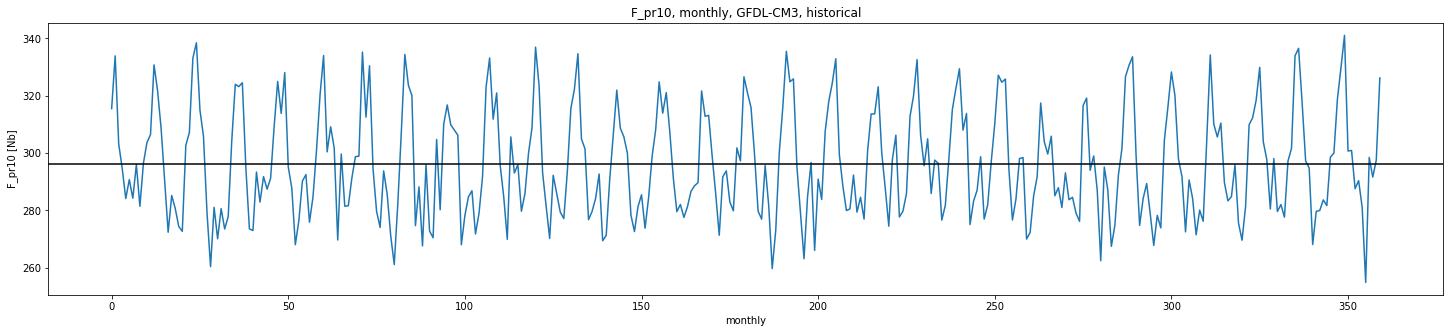

In [26]:
y = F_pr10.resample(time='M').mean(dim='time', keep_attrs=True)
variable_name = 'F_pr10'
series_type = 'monthly'

plot_timeseries(y, variable_name, series_type)

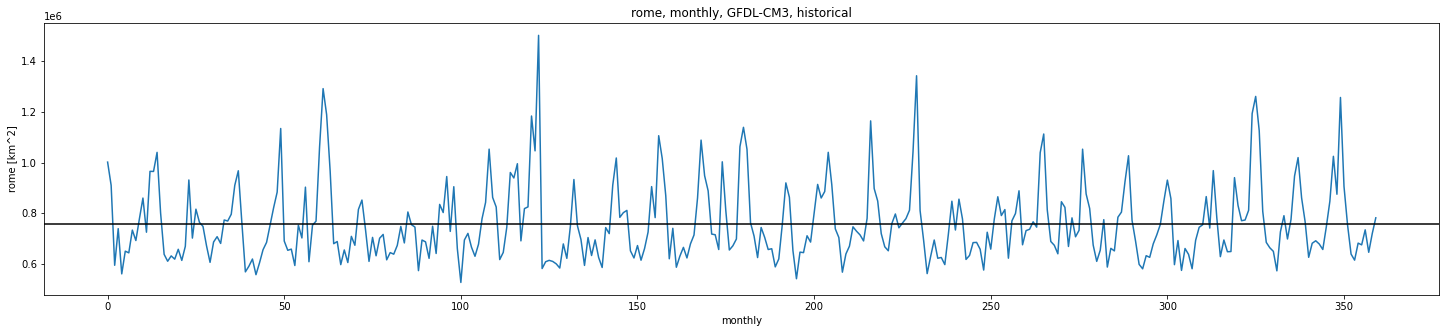

In [28]:
y = org.resample(time='M').mean(dim='time', keep_attrs=True)
variable_name = org_option
series_type = 'monthly'

plot_timeseries(y, variable_name, series_type)

## correlations

### monthly

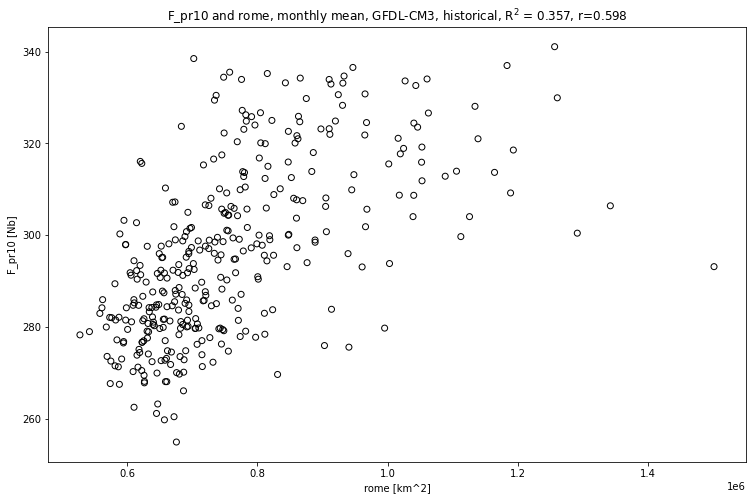

In [36]:
x = org.resample(time='M').mean(dim='time', keep_attrs=True)
y = F_pr10.resample(time='M').mean(dim='time', keep_attrs=True)
scatter_type = 'monthly mean'

plot_scatter(x,y,scatter_type)

### daily

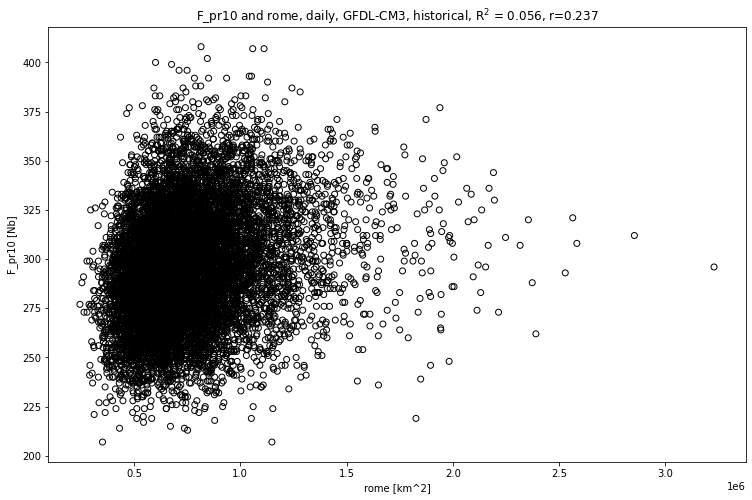

In [37]:
x = org
y = F_pr10
scatter_type = 'daily'

plot_scatter(x,y,scatter_type)

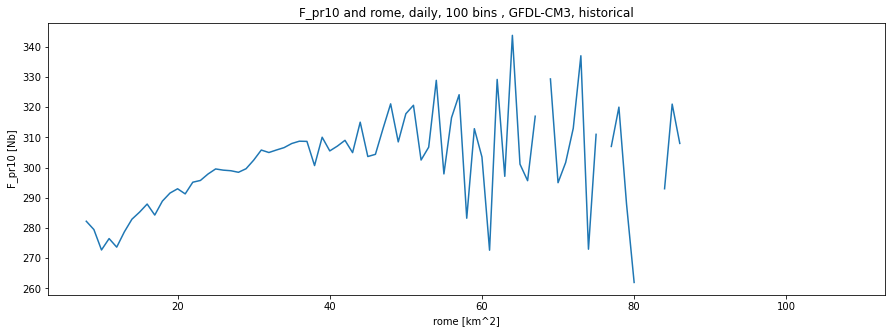

In [39]:
x = org
y = F_pr10
bin_type = 'daily, 100 bins '

plot_bins(x,y, bin_type)